# Classifying USD/JPY price direction
*** Using historical economical data ***

In [1]:
from fred import Fred

#imports
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import pandas as pd
import datetime
#from scipy.stats import ttest_ind_from_stats
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor #For Classification
from sklearn.metrics import confusion_matrix
import scipy.stats as sp
#from sklearn.model_selection import cross_val_score
from scipy.stats.stats import pearsonr
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn import tree
from IPython.display import Image  
import talib
#from scipy.stats import ttest_ind_from_stats
import MySQLdb
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
from scipy import stats
import datetime
from datetime import *
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neural_network import MLPClassifier

Get USDJPY daily OCHL prices from database 

In [4]:
# getting data
db_pass="XXXXX"
db_user="root"
db_name="quant"
db_table="USDJPY_D1"

try:
    #print(db)
    db = MySQLdb.connect("localhost","%s"%db_user,"%s"%db_pass,"%s"%db_name )
    #print(db)
    sql = "SELECT * FROM %s"%db_table
    currency = pd.read_sql(sql,db )
    
    currency['date']=currency.timestamp.apply(lambda x : datetime.date(pd.to_datetime(str(x))))
    currency['Y']=currency.close.diff()>0
    db.close()
except:
    print("Error: unable to fecth data")

Get other data from Fred API
https://fred.stlouisfed.org/

*** I picked some data series that is correlated with USDJPY and has enough observations available (6K+ observations)

These are the ID's of data I want to get from Fred API:
* NIKKEI225 - Nikkei Stock Average, Nikkei 225 - https://fred.stlouisfed.org/series/NIKKEI225
* DFF - Effective Federal Funds Rate - https://fred.stlouisfed.org/series/DFF
* DTB3 - 3-Month Treasury Bill: Secondary Market Rate - https://fred.stlouisfed.org/series/DTB3
* TEDRATE - TED Spread - https://fred.stlouisfed.org/series/TEDRATE
* USD1MTD156N - 1-Month London Interbank Offered Rate (LIBOR), based on U.S. Dollar - https://fred.stlouisfed.org/series/USD1MTD156N
* USD3MTD156N - 3-Month London Interbank Offered Rate (LIBOR), based on U.S. Dollar - https://fred.stlouisfed.org/series/USD3MTD156N



In [4]:
#from fred import Fred
fr = Fred(api_key='XXXXXXXX',response_type='dict')

params = {}

NIKKEI225=fr.series.observations("NIKKEI225", params=params)
DFF=fr.series.observations("DFF", params=params)
DTB3=fr.series.observations("DTB3", params=params)
TEDRATE=fr.series.observations("TEDRATE", params=params)
USD1MTD156N=fr.series.observations("USD1MTD156N", params=params)
USD3MTD156N=fr.series.observations("USD3MTD156N", params=params)
    
    
def tbl (res, nm ):
    x=pd.DataFrame()
    for record in res:
        x=x.append([[record["date"], record["value"]]])
    
    x=x.reset_index(drop=True)
    x.columns=["date", nm]
    x['date']=x.date.apply(lambda x : datetime.date(pd.to_datetime(str(x))))
    return x    
    

nikkei225=tbl(NIKKEI225, "nikkei225")
dff=tbl(DFF, "dff")
dtb3=tbl(DTB3, "dtb3")
tedrate=tbl(TEDRATE, "tedrate")
usd1mtd156n=tbl(USD1MTD156N, "usd1mtd156n")
usd3mtd156n=tbl(USD3MTD156N, "usd3mtd156n")


In [7]:
%store SP500
%store DJIA
%store NIKKEI225
%store DFF
%store DTB3
%store TEDRATE
%store USD1MTD156N
%store USD3MTD156N
%store VIXCLS

%store sp500
%store djia
%store nikkei225
%store dff
%store dtb3
%store tedrate
%store usd1mtd156n
%store usd3mtd156n
%store vixcls

%store currency


Stored 'SP500' (list)
Stored 'DJIA' (list)
Stored 'NIKKEI225' (list)
Stored 'DFF' (list)
Stored 'DTB3' (list)
Stored 'TEDRATE' (list)
Stored 'USD1MTD156N' (list)
Stored 'USD3MTD156N' (list)
Stored 'VIXCLS' (list)
Stored 'sp500' (DataFrame)
Stored 'djia' (DataFrame)
Stored 'nikkei225' (DataFrame)
Stored 'dff' (DataFrame)
Stored 'dtb3' (DataFrame)
Stored 'tedrate' (DataFrame)
Stored 'usd1mtd156n' (DataFrame)
Stored 'usd3mtd156n' (DataFrame)
Stored 'vixcls' (DataFrame)


In [2]:
%store -r SP500
%store -r DJIA
%store -r NIKKEI225
%store -r DFF
%store -r DTB3
%store -r TEDRATE
%store -r USD1MTD156N
%store -r USD3MTD156N
%store -r VIXCLS

%store -r sp500
%store -r djia
%store -r nikkei225
%store -r dff
%store -r dtb3
%store -r tedrate
%store -r usd1mtd156n
%store -r usd3mtd156n
%store -r vixcls
%store -r currency


Lets see how correlated is each variable with OHLC prices of USDJPY

* NIKKEI225 - Nikkei Stock Average, Nikkei 225 


In [39]:
r=nikkei225
print("Number of observations:")
print(pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().shape[0])
print("Date back to:")
print(pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().date[0:1][[0]])
pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().corr().drop(["Y"], axis=1)


Number of observations:
7729
Date back to:
         date
2  1978-01-04


,open,high,low,close,volume,nikkei225
open,1.000000,0.999912,0.999872,0.999832,-0.250475,-0.315224
high,0.999912,1.000000,0.999802,0.999895,-0.251269,-0.314528
low,0.999872,0.999802,1.000000,0.999915,-0.249963,-0.315674
close,0.999832,0.999895,0.999915,1.000000,-0.250569,-0.315021
volume,-0.250475,-0.251269,-0.249963,-0.250569,1.000000,0.034805
Y,-0.061785,-0.057611,-0.057727,-0.052527,0.065433,-0.008912
nikkei225,-0.315224,-0.314528,-0.315674,-0.315021,0.034805,1.000000


========================================================================= <br><br><br>
* DFF - Effective Federal Funds Rate


In [34]:
r=dff
print("Number of observations:")
print(pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().shape[0])
print("Date back to:")
print(pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().date[0:1][[0]])
pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().corr().drop(["Y"], axis=1)


Number of observations:
11903
Date back to:
         date
0  1978-01-01


,open,high,low,close,volume,dff
open,1.000000,0.999915,0.999882,0.999846,-0.233848,0.792378
high,0.999915,1.000000,0.999803,0.999897,-0.234516,0.793217
low,0.999882,0.999803,1.000000,0.999917,-0.233580,0.791944
close,0.999846,0.999897,0.999917,1.000000,-0.234021,0.792821
volume,-0.233848,-0.234516,-0.233580,-0.234021,1.000000,-0.416462
Y,-0.022627,-0.018807,-0.018470,-0.013702,0.033921,-0.015639
dff,0.792378,0.793217,0.791944,0.792821,-0.416462,1.000000


========================================================================= <br><br><br>
* DTB3 - 3-Month Treasury Bill: Secondary Market Rate


In [35]:
r=dtb3
print("Number of observations:")
print(pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().shape[0])
print("Date back to:")
print(pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().date[0:1][[0]])
pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().corr().drop(["Y"], axis=1)


Number of observations:
7781
Date back to:
         date
1  1978-01-03


,open,high,low,close,volume,dtb3
open,1.000000,0.999911,0.999869,0.999828,-0.247014,0.798675
high,0.999911,1.000000,0.999798,0.999891,-0.247871,0.799571
low,0.999869,0.999798,1.000000,0.999913,-0.246523,0.798250
close,0.999828,0.999891,0.999913,1.000000,-0.247150,0.799205
volume,-0.247014,-0.247871,-0.246523,-0.247150,1.000000,-0.455309
Y,-0.066220,-0.062067,-0.062153,-0.056879,0.061834,-0.053453
dtb3,0.798675,0.799571,0.798250,0.799205,-0.455309,1.000000


========================================================================= <br><br><br>
* TEDRATE - TED Spread 

In [36]:
r=tedrate
print("Number of observations:")
print(pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().shape[0])
print("Date back to:")
print(pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().date[0:1][[0]])
pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().corr().drop(["Y"], axis=1)


Number of observations:
6097
Date back to:
         date
0  1986-01-02


,open,high,low,close,volume,tedrate
open,1.000000,0.999496,0.999195,0.998889,-0.194935,0.333811
high,0.999496,1.000000,0.998949,0.999386,-0.196995,0.335448
low,0.999195,0.998949,1.000000,0.999515,-0.193957,0.330709
close,0.998889,0.999386,0.999515,1.000000,-0.195310,0.333207
volume,-0.194935,-0.196995,-0.193957,-0.195310,1.000000,-0.259957
Y,-0.085452,-0.076073,-0.075818,-0.063035,0.064172,-0.033606
tedrate,0.333811,0.335448,0.330709,0.333207,-0.259957,1.000000


========================================================================= <br><br><br>
* USD1MTD156N - 1-Month London Interbank Offered Rate (LIBOR), based on U.S. Dollar

In [37]:
r=usd1mtd156n
print("Number of observations:")
print(pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().shape[0])
print("Date back to:")
print(pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().date[0:1][[0]])
pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().corr().drop(["Y"], axis=1)


Number of observations:
6304
Date back to:
         date
0  1986-01-02


,open,high,low,close,volume,usd1mtd156n
open,1.000000,0.999491,0.999203,0.998893,-0.195277,0.639528
high,0.999491,1.000000,0.998951,0.999390,-0.197389,0.642367
low,0.999203,0.998951,1.000000,0.999515,-0.194290,0.637628
close,0.998893,0.999390,0.999515,1.000000,-0.195728,0.640558
volume,-0.195277,-0.197389,-0.194290,-0.195728,1.000000,-0.518750
Y,-0.084924,-0.075524,-0.075299,-0.062524,0.063440,-0.071443
usd1mtd156n,0.639528,0.642367,0.637628,0.640558,-0.518750,1.000000


========================================================================= <br><br><br>
* USD3MTD156N - 3-Month London Interbank Offered Rate (LIBOR), based on U.S. Dollar 

In [38]:
r=usd3mtd156n
print("Number of observations:")
print(pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().shape[0])
print("Date back to:")
print(pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().date[0:1][[0]])
pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].reset_index(drop=True)], axis=1).dropna().corr().drop(["Y"], axis=1)


Number of observations:
6304
Date back to:
         date
0  1986-01-02


,open,high,low,close,volume,usd3mtd156n
open,1.000000,0.999491,0.999203,0.998893,-0.195277,0.629054
high,0.999491,1.000000,0.998951,0.999390,-0.197389,0.631858
low,0.999203,0.998951,1.000000,0.999515,-0.194290,0.627152
close,0.998893,0.999390,0.999515,1.000000,-0.195728,0.630054
volume,-0.195277,-0.197389,-0.194290,-0.195728,1.000000,-0.516548
Y,-0.084924,-0.075524,-0.075299,-0.062524,0.063440,-0.071026
usd3mtd156n,0.629054,0.631858,0.627152,0.630054,-0.516548,1.000000


========================================================================= <br><br><br>
Start creating our dataset which will include percentage of change of each observation in each variables from previous day and the correlation coefficient of each variable with close price of USDJPY in the previous 200 days since correlations changes from time to time (next plot shows how correlations changes from time to time)


In [3]:
r=usd3mtd156n
XX=pd.concat([currency[currency.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(currency.date)].usd3mtd156n.reset_index(drop=True)], axis=1).dropna().drop(["timestamp"], axis=1)
r=usd1mtd156n
XX=pd.concat([XX[XX.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(XX.date)].usd1mtd156n.reset_index(drop=True)], axis=1).dropna()
r=dtb3
XX=pd.concat([XX[XX.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(XX.date)].dtb3.reset_index(drop=True)], axis=1).dropna()
r=dff
XX=pd.concat([XX[XX.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(XX.date)].dff.reset_index(drop=True)], axis=1).dropna()
r=nikkei225
XX=pd.concat([XX[XX.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(XX.date)].nikkei225.reset_index(drop=True)], axis=1).dropna()
r=tedrate
XX=pd.concat([XX[XX.date.isin(r.date)].reset_index(drop=True), r[r.date.isin(XX.date)].tedrate.reset_index(drop=True)], axis=1).dropna()

In [4]:
XX=XX.reset_index(drop=True)
t=200
cr=pd.DataFrame()
for j in range(0, len(XX.columns)):
    tt=[]
    if (XX.columns[j] == "date") | (XX.columns[j] == "Y") | (XX.columns[j] == "close") | (XX.columns[j] == "open"):
        continue
    for i in range(0, len(XX)):
        if i<t:
            tt.append(np.nan)
            continue
        tt.append(pearsonr(XX.icol(j)[i-t:i], XX.close[i-t:i])[0])
         
    h="corr_%s"%XX.columns[j]
    cr[h]=tt
        
    

Plot shows the correlation coefficient of previous 200 day at each observation in our dataset

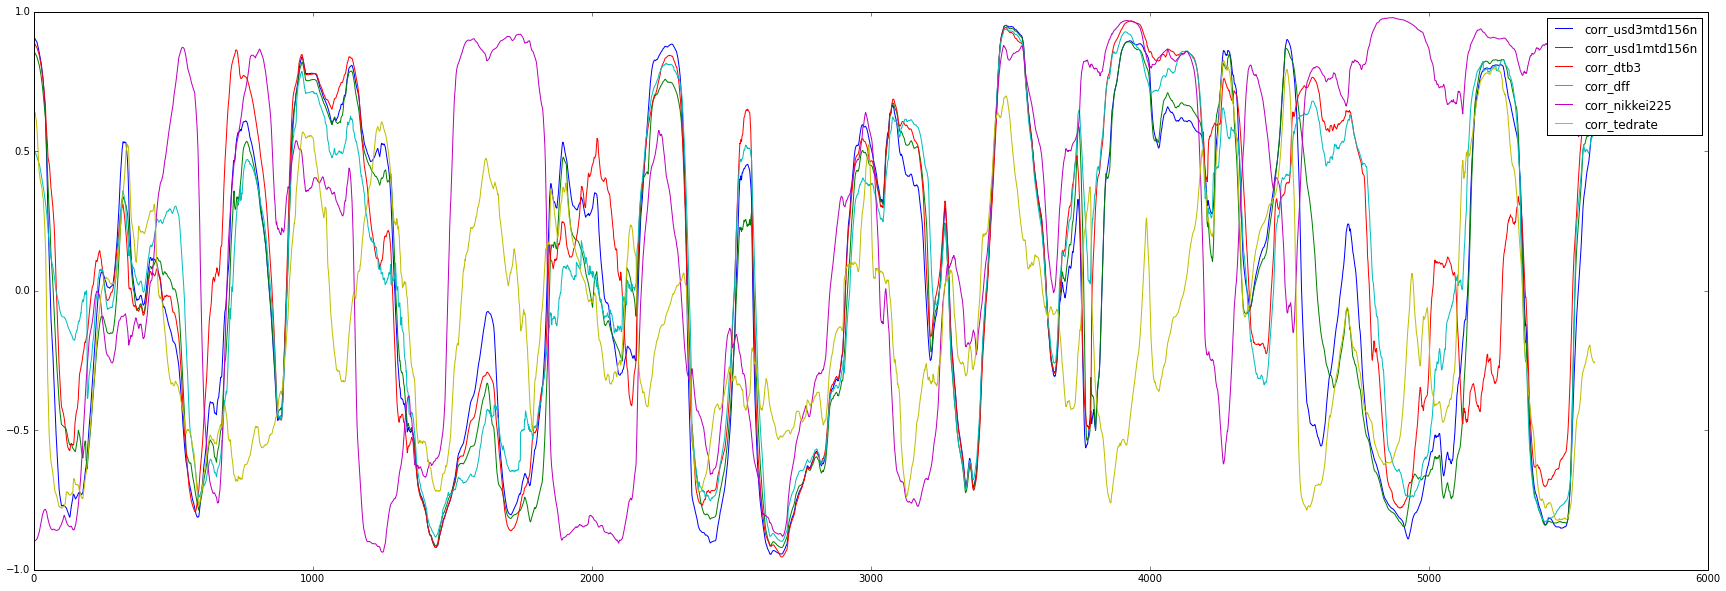

In [139]:
plt.figure(figsize=(30,10))
plt.plot(cr[200::].drop(["corr_high","corr_low","corr_volume"],axis=1), )
plt.legend(cr.drop(["corr_high","corr_low","corr_volume"], axis=1).columns)

In [6]:

XT=XX.drop(["date","Y"], axis=1).pct_change()
XX=XX.join(cr)
XX=XX.join(XT, rsuffix="__")[1::]

si=0
XX=XX.reset_index(drop=True)
Xtrain=XX[0:len(XX)-si]
#Xtest=XX[-si::]
#Xtest=Xtest.reset_index(drop=True)
Xtrain=Xtrain.replace([np.inf, -np.inf], np.nan).dropna()
Ytrain=Xtrain.Y
#Ytest=Xtest.Y
Xtrain=Xtrain.shift(1)
#Xtest=Xtest.shift(1)

#Xtest=Xtest.dropna()
Xtrain=Xtrain.dropna()
Ytrain=Ytrain[Xtrain.index]
#Ytest=Ytest[Xtest.index]

In [7]:
Xtrain=Xtrain.drop(["date", "Y"], axis=1)
#Xtest=Xtest.drop(["date", "Y"], axis=1)


Now we ended up with a dataset from: 1987-01-21 to 2017-06-06 (5593 observations).
Here is how it looks. <br>
Column names with "corr_" as prefix are the correlation coeffiecients while column names with "__" as suffix are the percentages of change

In [8]:
Xtrain=Xtrain.reset_index(drop=True)
nk=Xtrain.columns[11::]
Xtrain[nk].head()

,corr_high,corr_low,corr_volume,corr_usd3mtd156n,corr_usd1mtd156n,corr_dtb3,corr_dff,corr_nikkei225,corr_tedrate,open__,high__,low__,close__,volume__,usd3mtd156n__,usd1mtd156n__,dtb3__,dff__,nikkei225__,tedrate__
0,0.998440,0.998886,0.173593,0.905160,0.854954,0.889415,0.511248,-0.899779,0.629811,-0.003393,-0.002209,-0.001382,-0.002422,0.307692,0.000000,-0.002520,0.001887,-0.009788,0.011089,-0.011236
1,0.998399,0.998867,0.142390,0.905214,0.854134,0.888596,0.503163,-0.899014,0.633550,-0.002422,-0.003385,0.000000,0.000000,-0.205882,0.000000,0.000000,0.013183,0.001647,-0.002506,-0.079545
2,0.998356,0.998837,0.146292,0.904616,0.852961,0.888071,0.501109,-0.898371,0.628356,-0.001903,-0.003528,-0.000264,-0.002494,-0.370370,0.010101,0.010101,0.020446,0.009868,0.008988,-0.061728
3,0.998321,0.998801,0.151383,0.903850,0.852149,0.887466,0.500589,-0.897596,0.622538,-0.000592,-0.001901,-0.006330,-0.004013,-0.411765,0.000000,0.000000,0.000000,0.001629,0.006756,0.000000
4,0.998288,0.998762,0.164323,0.904208,0.852678,0.885667,0.500474,-0.897213,0.638504,-0.004013,0.009195,0.000000,0.008983,1.800000,0.000000,0.000000,-0.003643,0.056911,0.005237,0.026316


It has 31 observations with "inf" values resulted when we calculated percentages of change, I'll remove those rows from our dataset

In [202]:
#(Xtrain==np.inf).sum()
Xtrain=Xtrain.replace([np.inf, -np.inf], np.nan).dropna()


Now I am going to use Gradient Boosting Classifier with 1000 estimators and 500 min_samples_leaf to train our model.
<br><br>
I'll use a sliding window of size 111 to train and test the model, which means using the first 111 observations as test data and the rest of the data as training data, get the results then use the next 111 observations as test data and so on till the last 111 observations, in other words, I'll do 50 folds cross validation.

In [141]:
k_fold = KFold(n_splits=50)
cval=cross_val_score(estimator=GradientBoostingClassifier(n_estimators=1000, min_samples_leaf=500),verbose=True, cv=k_fold,X=Xtrain[nk], y=Ytrain, n_jobs=-1)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.6min finished


Accuracy score: 

In [143]:
cval.mean()

0.56080920205920204

Looks good? it does but lets dive deeper. this is a plot that shows the score of each 111 observation

Why does it have high accuracy scores in the beginning unlike the more recent data?

Next plot shows - in each 111 observations - the percentage of observations where the price moves up 

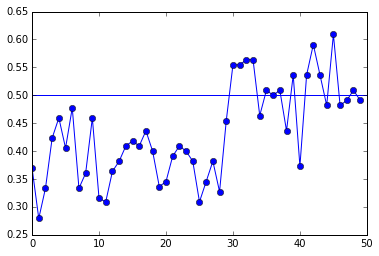

In [148]:
yy=[]
for train_indices, test_indices in k_fold.split(Xtrain):
    yy.append(Ytrain[test_indices[0]:test_indices[len(test_indices)-1]].mean())

plt.plot(yy,"o-")
plt.axhline(0.5)
plt.show()

Now lets compare our model to other three models, a random one, a model that always predicts upward movement and a model that always predicts downward movement. <br>


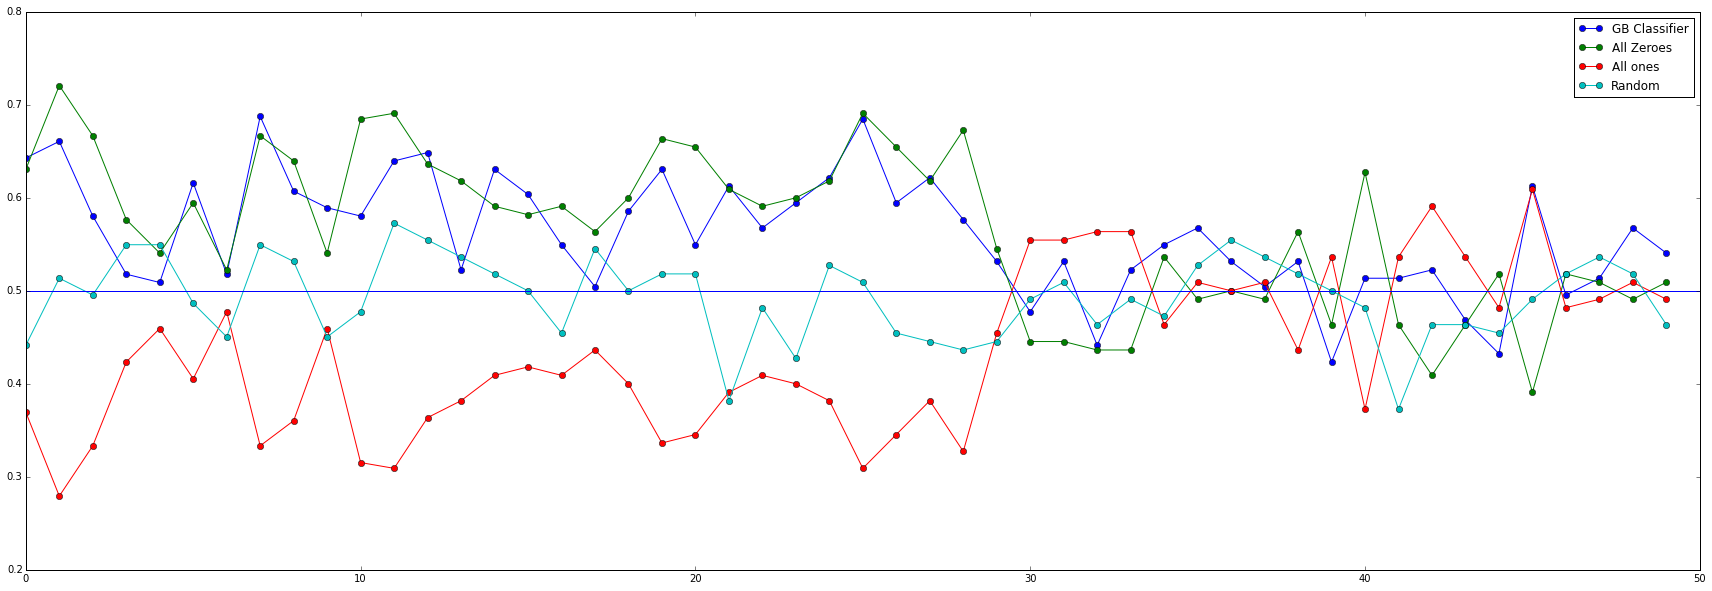

In [193]:
ones=np.repeat(1,len(Ytrain))
ones=ones==Ytrain
zeroes=np.repeat(0,len(Ytrain))
zeroes=zeroes==Ytrain
'''
rnds=[]
for train_indices, test_indices in k_fold.split(Xtrain):
    s=[]
    for i in range(0,100):
        rs=pd.Series(np.random.sample(size=test_indices[len(test_indices)-1]-test_indices[0])>=0.5)
        rs=rs==Ytrain[test_indices[0]:test_indices[len(test_indices)-1]]
        s.append(rs.mean())
    rnds.append(np.mean(s))
    
'''

rs=pd.Series(np.random.sample(size=len(Ytrain))>=0.5)
rs=rs==Ytrain
r=[]
o=[]
z=[]
for train_indices, test_indices in k_fold.split(Xtrain):
    #print('test:%s %s' % (test_indices[0], test_indices[len(test_indices)-1]))
    r.append(rs[test_indices[0]:test_indices[len(test_indices)-1]].mean())
    o.append(ones[test_indices[0]:test_indices[len(test_indices)-1]].mean())
    z.append(zeroes[test_indices[0]:test_indices[len(test_indices)-1]].mean())
    

plt.figure(figsize=(30,10))
plt.plot(cval, "o-", label="GB Classifier")
plt.plot(pd.Series(z), "o-",label="All Zeroes")
plt.plot(pd.Series(o),"o-", label="All ones")
plt.plot(r,"o-", label="Random")
plt.legend()
plt.show
plt.axhline(0.50)


## Further Work:
* Add more economical data 
* Do more feature engineering
* Experiment other currency pairs